# Taha Smavati - 98722134 - Pattern Recognition
## First Project - PART 4 Word2Vec
### Table of contents:
    4. Word2Vec representation - with and without stopwords removal
      Preprocessing
      4.1. Gaussian Naive Bayes
        4.1.1. Evaluation : Confusion matrix + ROC
      4.2.SVM
        4.2.1 Evaluation : Confusion matrix + ROC
      4.3.Decision Tree
        4.3.1 Evaluation : Confusion matrix + ROC
      4.4.Random Forest
        4.4.1 Evaluation : Confusion matrix + ROC
      4.5. Performance Comparison of classifiers - Word2Vec

In [0]:
import numpy as np
import nltk
import re
import pandas as pd
import os
import natsort
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import gensim

# 4. Word2Vec - with and without stop word removal

In [0]:
# Load data
df_train = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_train_df.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_test_df.csv')

y_train = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_train.npy')
y_test = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_test.npy')

Tokenization

In [0]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df_train["tokens"] = df_train["comment"].apply(tokenizer.tokenize)
df_test['tokens'] = df_train['comment'].apply(tokenizer.tokenize)

**Remove stop words**

In [0]:
# Load library
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load stop words
stop_words = stopwords.words('english')

def remove_stopwords(listin):
  x=set(listin)
  out = []
  for token in x :
    if token not in stop_words:
      out.append(token)
  return out

df_train["tokens_stwrmv"] = df_train["tokens"].apply(remove_stopwords)
df_test['tokens_stwrmv'] = df_train['tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* Below functions generate word2vec embeddings for each comment
* For each token in a comment the Word2vec embeddings are generated then the **average** of all tokens is computed

In [0]:
def get_average_word2vec(tokens_list,vector,generate_missing=False,k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    # if generate missing is true then generate random vector for words that doesn't have word2vec embedding
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
    # if it's false then generate zero vector
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    # Average word vectors in each comment
    averaged = np.divide(summed, length)
    return averaged

# generate word2vec embeddings for comments
def get_word2vec_embeddings(vectors, dataframe, generate_missing=False):
    embeddings = dataframe['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    
    return list(embeddings)
# generate word2vec embeddings for comments with removed stop words
def get_word2vec_embeddings_stw(vectors, dataframe, generate_missing=False):
    embeddings = dataframe['tokens_stwrmv'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    
    return list(embeddings)

* Load word2vec model

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Pattern_Recognition/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


* Create X_train and X_test for both experiments : 1.with stop words 2. without stop words

In [0]:
# Train and test data with stop words
X_train_word2vec=get_word2vec_embeddings(model,df_train)
X_test_word2vec = get_word2vec_embeddings(model,df_test)
# Train and test data without stop words
X_test_word2vec_strem = get_word2vec_embeddings_stw(model,df_test)
X_train_word2vec_strem = get_word2vec_embeddings_stw(model,df_train)

## 4.1 Gaussian Naive Bayes

In [0]:
# Create and fit Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb1 = GaussianNB()
gnb_model = gnb.fit(X_train_word2vec,y_train)
gnb_model = gnb1.fit(X_train_word2vec_strem,y_train)

### 4.1.1 EVALUATION

In [0]:
# Predict and print metrics
y_pred = np.zeros(len(X_test_word2vec),dtype=np.int8)
y_pred_strem = np.zeros(len(X_test_word2vec),dtype=np.int8)
for i in range(len(X_test_word2vec)):
    y_pred[i] = gnb.predict([X_test_word2vec[i]])
    y_pred_strem[i] = gnb1.predict([X_test_word2vec_strem[i]])
#y_pred = gnb.predict(X_test)
precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_strem, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions=[]
precisions1=[]
precisions.append(precision)
precisions1.append(precision1)

Presicion = 73.40016944864725 % Recall = 73.236 % f1 = 73.18897522134145 %
Presicion = 78.04127655392683 % Recall = 77.99199999999999 % f1 = 77.98232716073998 %


In [0]:
def plot_confusion_matrix(y_true,y_predicted, classes, normalize=False, title=None, cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = "Normalized Confusion matrix"
        else:
            title = "Confusion matrix, Without normalization"
    cm = confusion_matrix(y_true, y_predicted)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel="predicted label")
    plt.setp(ax.get_xticklabels(), rotation=45,ha='right', rotation_mode='anchor')
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

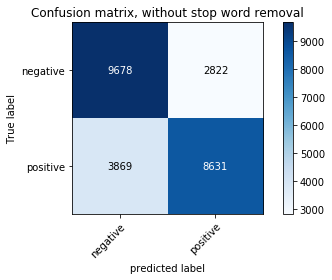

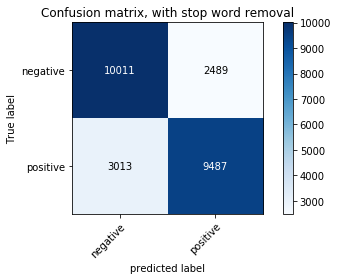

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

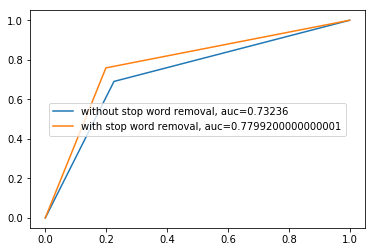

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

## 4.2. SVM Classifier

In [0]:
svmc = LinearSVC(C=0.01)
svmc1 = LinearSVC(C=0.01)
svmc.fit(X_train_word2vec,y_train)
svmc1.fit(X_train_word2vec_strem,y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 4.2.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_svm = np.zeros(len(X_test_word2vec),dtype=np.int8)
y_pred_svm_strem = np.zeros(len(X_test_word2vec),dtype=np.int8)
for i in range(len(X_test_word2vec)):
    y_pred_svm[i] = svmc.predict([X_test_word2vec[i]])
    y_pred_svm_strem[i] = svmc1.predict([X_test_word2vec_strem[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_svm_strem, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Without stop word Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

Presicion = 81.20629138552835 % Recall = 81.196 % f1 = 81.19444955006539 %
Without stop word Presicion = 83.3686697225488 % Recall = 83.368 % f1 = 83.36791654685805 %


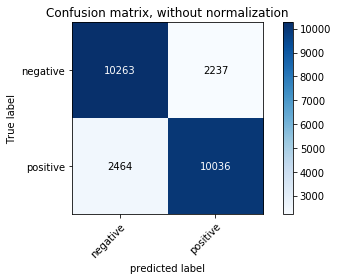

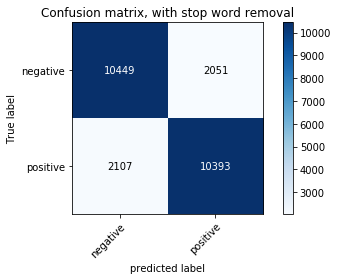

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

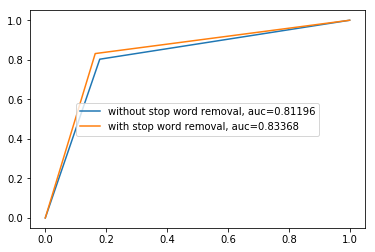

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_svm_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

## 4.3. Decision Tree Classifier

In [0]:
dtc = DTC(random_state=76)
dtc1 = DTC(random_state=76)
dtc.fit(X_train_word2vec,y_train)
dtc1.fit(X_train_word2vec_strem,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=76, splitter='best')

### 2.3.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_dtc = np.zeros(len(X_test_word2vec),dtype=np.int8)
y_pred_dtc_strem = np.zeros(len(X_test_word2vec),dtype=np.int8)
for i in range(len(X_test_word2vec)):
    y_pred_dtc[i] = dtc.predict([X_test_word2vec[i]])
    y_pred_dtc_strem[i] = dtc1.predict([X_test_word2vec_strem[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_dtc, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_dtc_strem, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Without stop word Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

Presicion = 100.0 % Recall = 100.0 % f1 = 100.0 %
Without stop word Presicion = 100.0 % Recall = 100.0 % f1 = 100.0 %


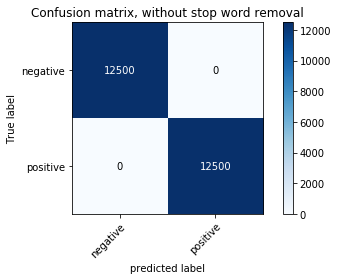

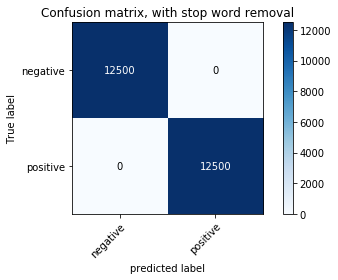

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

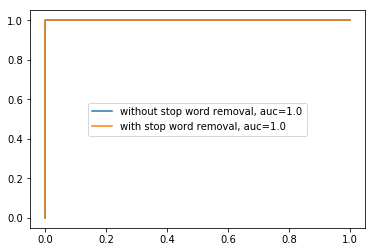

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_dtc_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

## 4.4 Random Forest classifier

In [0]:
rfc = RandomForestClassifier(n_estimators=24, random_state=42)
rfc1 = RandomForestClassifier(n_estimators=24, random_state=42)
rfc.fit(X_train_word2vec,y_train)
rfc1.fit(X_train_word2vec_strem,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=24,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 2.4.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_rfc = np.zeros(len(X_test_word2vec),dtype=np.int8)
y_pred_rfc_strem = np.zeros(len(X_test_word2vec),dtype=np.int8)
for i in range(len(X_test_word2vec)):
    y_pred_rfc[i] = rfc.predict([X_test_word2vec[i]])
    y_pred_rfc_strem[i] = rfc1.predict([X_test_word2vec_strem[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_rfc, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_rfc_strem, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Without stop word Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

Presicion = 99.9240156561713 % Recall = 99.924 % f1 = 99.9239999940416 %
Without stop word Presicion = 99.92003194882045 % Recall = 99.92 % f1 = 99.9199999872 %


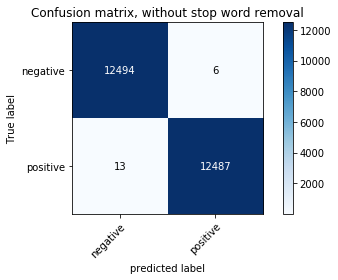

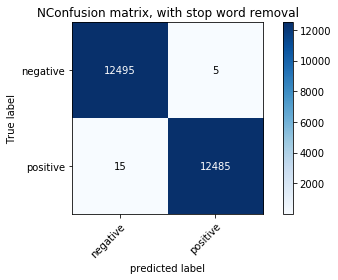

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc_strem, classes=['negative','positive'],
                      title='NConfusion matrix, with stop word removal')

plt.show()

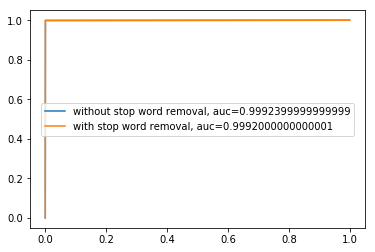

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_rfc_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

# 4.5 Comparison  - Word2vec representation

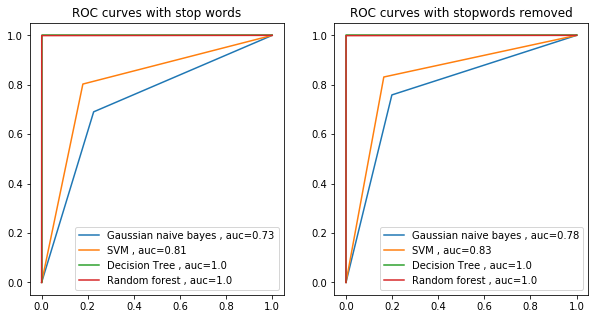

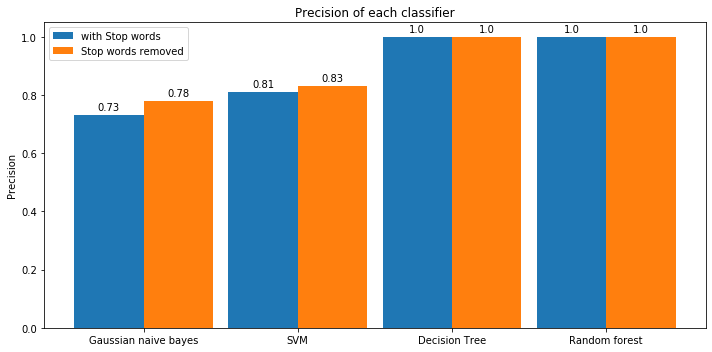

In [0]:
def autolabel(rects):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Compare ROC and AUC among different classifiers
y_preds = [y_pred, y_pred_svm, y_pred_dtc, y_pred_rfc]
y_preds_st = [y_pred_strem, y_pred_svm_strem, y_pred_dtc_strem, y_pred_rfc_strem]
clsf_names=['Gaussian naive bayes','SVM','Decision Tree','Random forest']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(len(y_preds)):

  fpr, tpr, _ = roc_curve(y_test, y_preds[i])
  roc_auc = auc(fpr, tpr)
  ax[0].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[0].legend(loc=4)
ax[0].set_title('ROC curves with stop words')

for i in range(len(y_preds_st)):

  fpr, tpr, _ = roc_curve(y_test, y_preds_st[i])
  roc_auc = auc(fpr, tpr)
  ax[1].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[1].legend(loc=4)
ax[1].set_title('ROC curves with stopwords removed')

plt.show()

fig, ax = plt.subplots(figsize=(10,5))
labels = clsf_names
data = np.round(precisions,2)
data_stp_rem = np.round(precisions1,2)

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars


rects1 = ax.bar(x - width/2, data, width, label="with Stop words")
rects2 = ax.bar(x + width/2, data_stp_rem, width, label="Stop words removed")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision of each classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

* From figures above The performance of classifiers didn't improve significantly by removing stop words
* Best performing classifiers are Decision Tree and Random forest
* Concolusion : removing stop words is not necessary when using word2vec method
* Word 2 vec in much more robust than tf-idf